In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install git+https://github.com/surmenok/keras_lr_finder

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-v7tqay34
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-v7tqay34
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301577 sha256=a5499cd300589e12f48d6733b6b66ebf523d9951714cda32f8075793f7b93bac
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_6nmwpl/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Successfully built tensorflow-examples
  Cloning https://github.com/surmenok/keras_lr_finder to /tmp/pip-req-build-f8i2evag
  Running command git clone -q https://github.com/surmenok/keras_lr_finder /tmp/pip-req-build-f8i2evag
  Created wheel for keras-lr-finder: filename=keras_lr_finder-0.1-py3-none-any.whl size=4001 sha256=7c793dcd148c26b16c54e615c30d41292ba019973fcd8b086ee2aedfbcb57eb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_61opgn/whe

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from keras_lr_finder import LRFinder
from tensorflow import keras

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [4]:
def Read_All_Data(path):
    temp = []
    updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","trainval.txt")
    with open(updated_path,"r") as file_:
        Instances = file_.read().split()
        img_arr = []
        seg_arr = []
        for img in Instances:
            path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
            path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
            img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg[seg == 255] = 21
            img_arr.append(img)
            seg_arr.append(seg)
    return np.array(img_arr), np.array(seg_arr)

In [5]:
path = "../input/pascal-voc-2012"
full_dataset = tf.data.Dataset.from_tensor_slices(Read_All_Data(path))

In [6]:
DATASET_SIZE = 2913

In [7]:

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [8]:
def Read_Data(path,is_train = True):
    temp = []
    updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
    with open(updated_path,"r") as file_:
        Instances = file_.read().split()
        img_arr = []
        seg_arr = []
        for img in Instances:
            path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
            path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
            img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg[seg == 255] = 21
            img_arr.append(img)
            seg_arr.append(seg)
    return np.array(img_arr), np.array(seg_arr)

In [9]:
path = "../input/pascal-voc-2012"
train_data = Read_Data(path, is_train = True)
val_data   = Read_Data(path, is_train = False)

In [10]:
TRAIN_LENGTH = train_data[0].shape[0]
TEST_LENGTH = val_data[0].shape[0]

In [11]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
test_dataset = tf.data.Dataset.from_tensor_slices(val_data)

### We need some agumentation while loading the training set in order to prevent overfitting 

In [13]:
def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]
    

    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [14]:
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [15]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [16]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [17]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

### show an example of image and mask

(256, 256, 3)


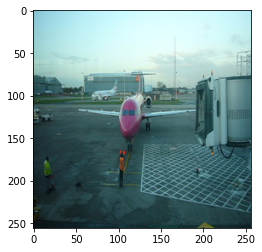

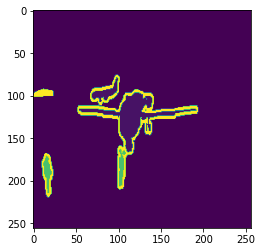

(256, 256, 3)


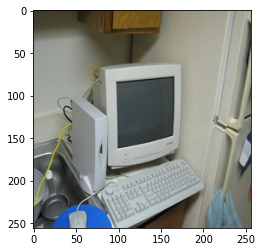

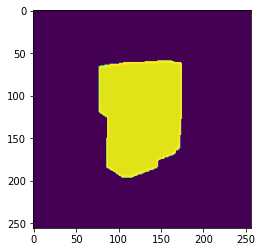

In [18]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    plt.imshow(sample_image)
    print(sample_image.shape)
    plt.show()
    plt.imshow(sample_mask)
    plt.show()

In [19]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# use the output of listed layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# we'll not change the parameter of the decoder
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [20]:
# build the upsampling model (decoder)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extract features 
    skips = down_stack(x)
    x = skips[-1]
    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer 
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### find the optimal learning rate

In [22]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Epoch 1/10
47/47 [==============================] - 14s 166ms/step - loss: 3.2795 - accuracy: 0.0475
Epoch 2/10
47/47 [==============================] - 7s 156ms/step - loss: 3.2840 - accuracy: 0.0475
Epoch 3/10
47/47 [==============================] - 7s 156ms/step - loss: 3.2826 - accuracy: 0.0468
Epoch 4/10
47/47 [==============================] - 7s 156ms/step - loss: 3.2829 - accuracy: 0.0471
Epoch 5/10
47/47 [==============================] - 7s 156ms/step - loss: 3.2617 - accuracy: 0.0500
Epoch 6/10
47/47 [==============================] - 7s 155ms/step - loss: 3.0698 - accuracy: 0.0958
Epoch 7/10
47/47 [==============================] - 7s 155ms/step - loss: 1.9195 - accuracy: 0.6225
Epoch 8/10
47/47 [==============================] - 7s 155ms/step - loss: 1.2559 - accuracy: 0.7015
Epoch 9/10
47/47 [==============================] - 4s 82ms/step - loss: 3.7257 - accuracy: 0.5683


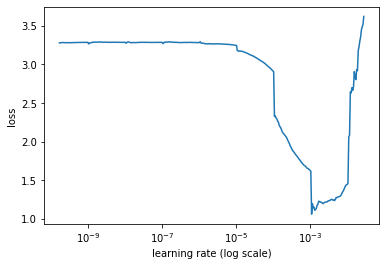

In [23]:
x, y = next(iter(val_dataset))

for x_, y_ in val_dataset:
    x = tf.concat((x, x_), axis=0)
    y = tf.concat((y, y_), axis=0)
    
# use lr_finder to draw the cycling learning rate
lr_finder = LRFinder(model)
lr_finder.find(x, y, start_lr=1e-10, end_lr=1, batch_size=32, epochs=10)
lr_finder.plot_loss()

### From the above figure, 1e-4 is the optimal learning rate

In [24]:
optimizer = keras.optimizers.Adam(lr=1e-4)

In [25]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

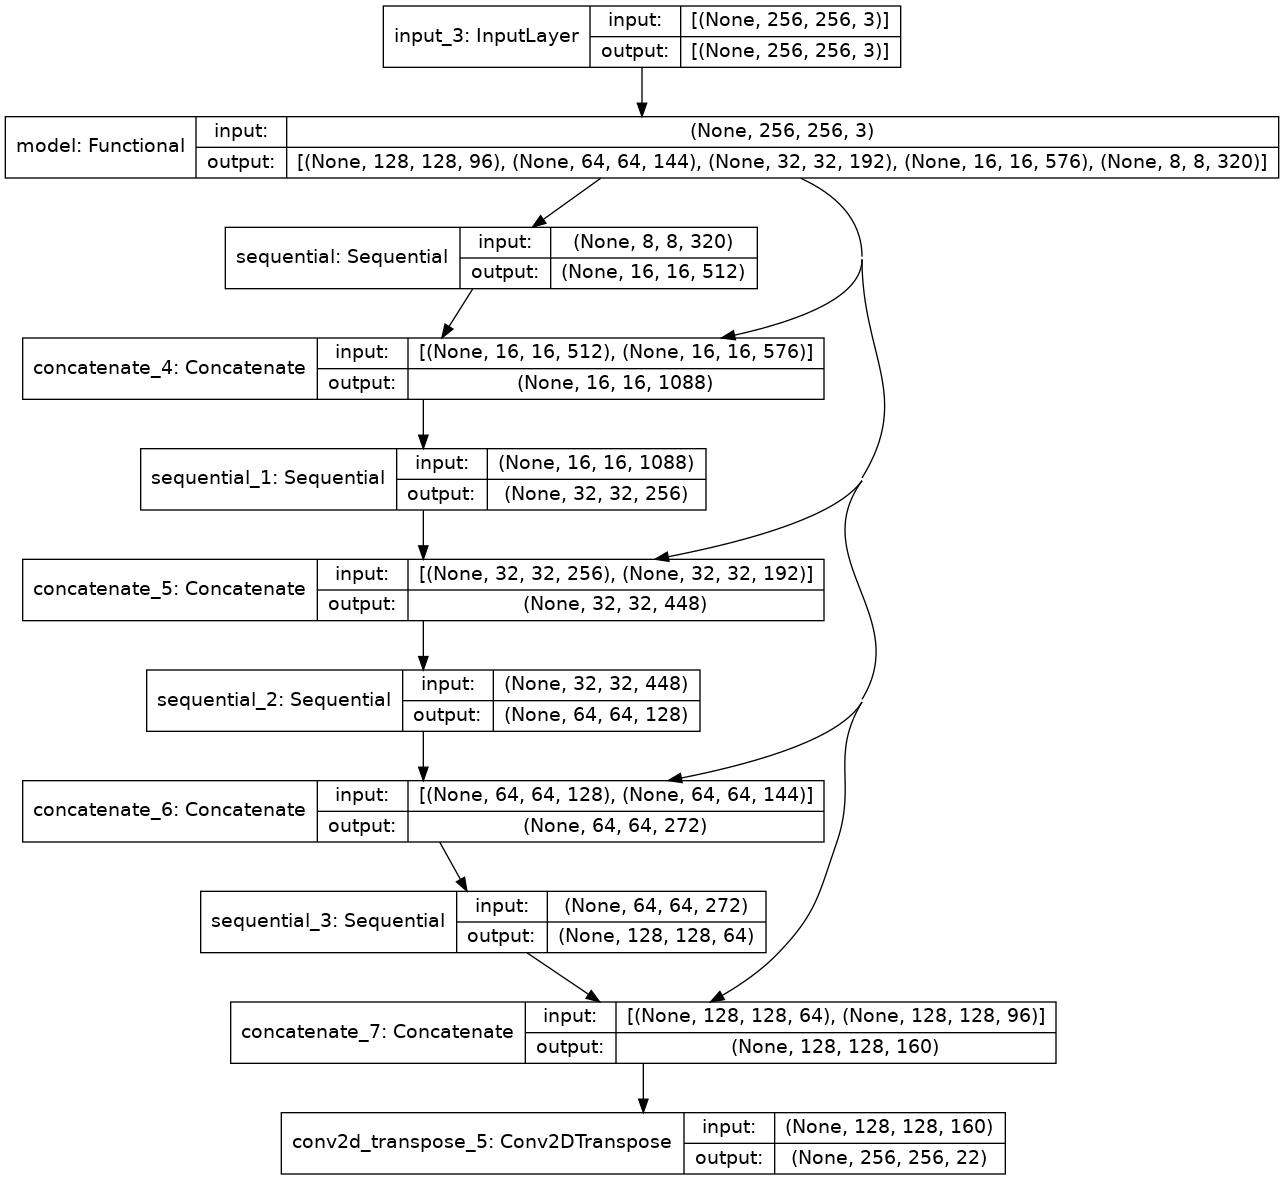

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [29]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/30
63/63 [==============================] - 15s 184ms/step - loss: 2.9241 - accuracy: 0.1975 - val_loss: 1.7741 - val_accuracy: 0.6798
Epoch 2/30
63/63 [==============================] - 10s 162ms/step - loss: 1.5654 - accuracy: 0.6909 - val_loss: 1.3895 - val_accuracy: 0.7043
Epoch 3/30
63/63 [==============================] - 10s 162ms/step - loss: 1.2787 - accuracy: 0.7136 - val_loss: 1.2611 - val_accuracy: 0.7064
Epoch 4/30
63/63 [==============================] - 10s 163ms/step - loss: 1.1700 - accuracy: 0.7238 - val_loss: 1.1840 - val_accuracy: 0.7132
Epoch 5/30
63/63 [==============================] - 10s 163ms/step - loss: 1.0973 - accuracy: 0.7273 - val_loss: 1.0994 - val_accuracy: 0.7258
Epoch 6/30
63/63 [==============================] - 10s 163ms/step - loss: 1.0084 - accuracy: 0.7465 - val_loss: 1.0263 - val_accuracy: 0.7387
Epoch 7/30
63/63 [==============================] - 10s 162ms/step - loss: 0.9547 - accuracy: 0.7561 - val_loss: 0.9617 - val_accuracy: 0.7527

In [30]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [31]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

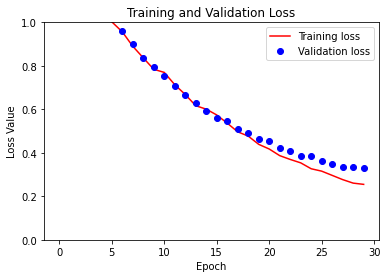

In [32]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

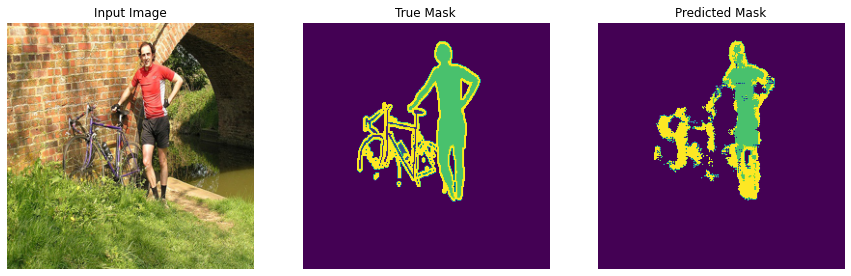

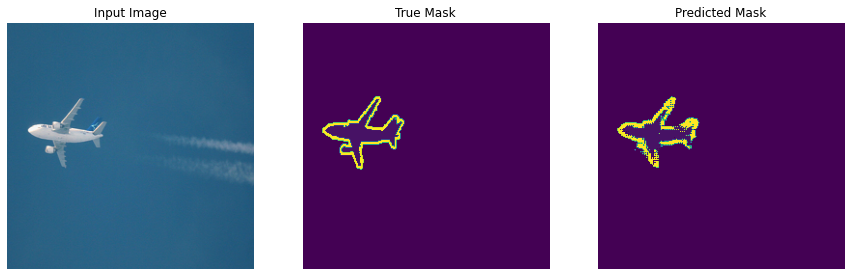

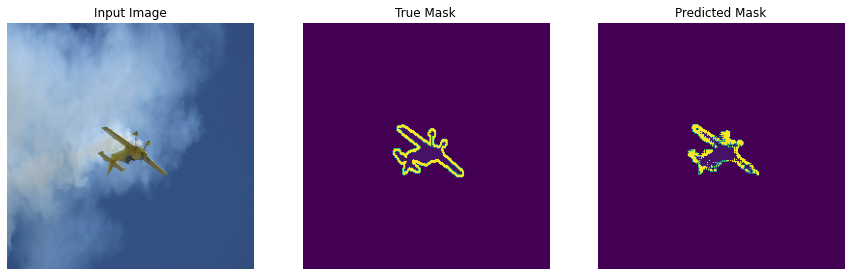

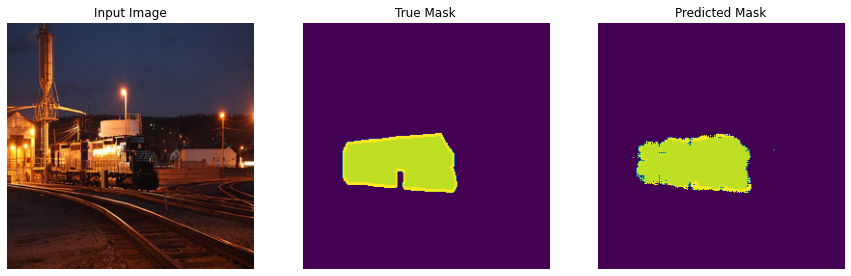

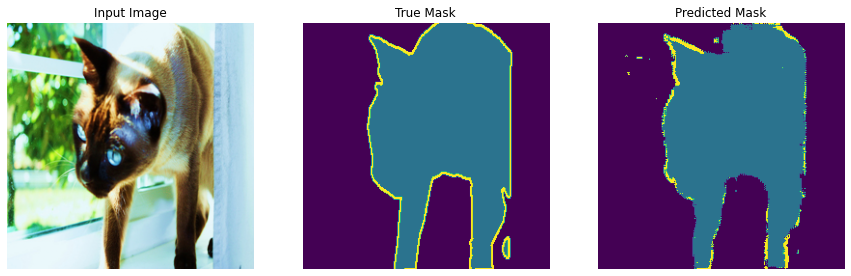

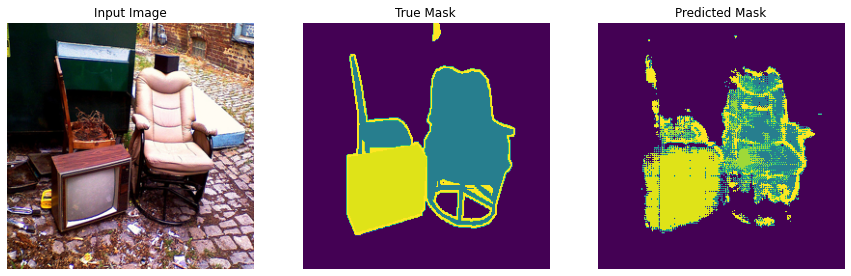

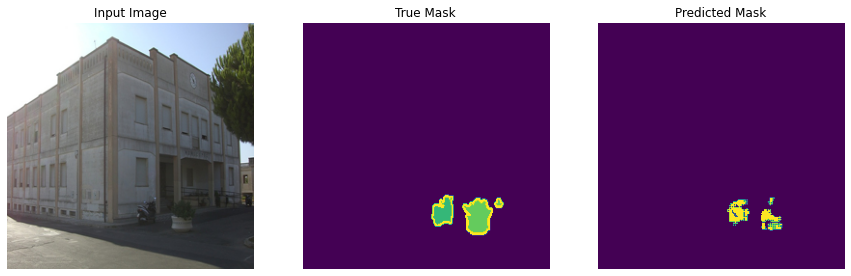

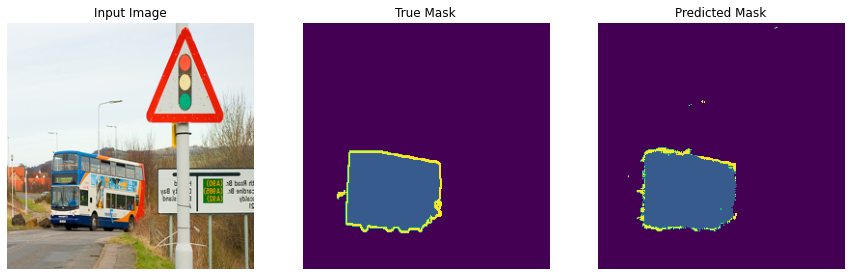

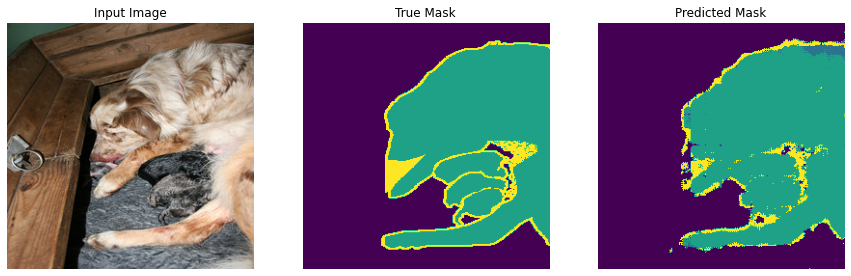

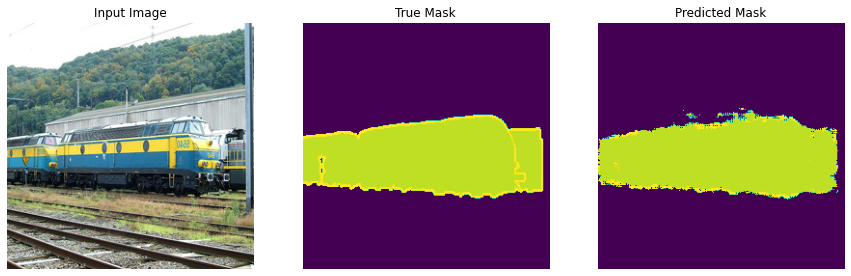

In [33]:
show_predictions(train_dataset, num =10)

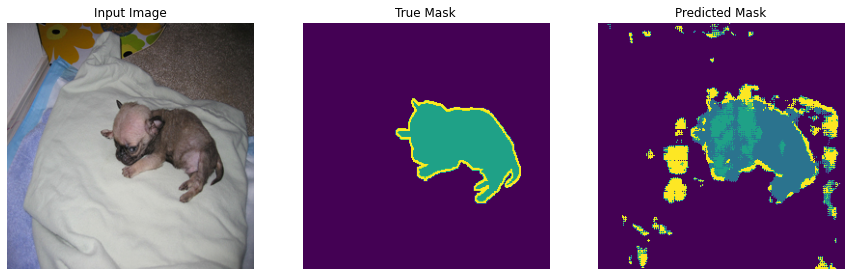

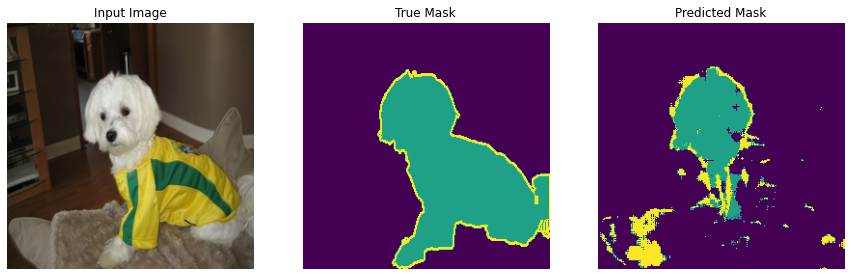

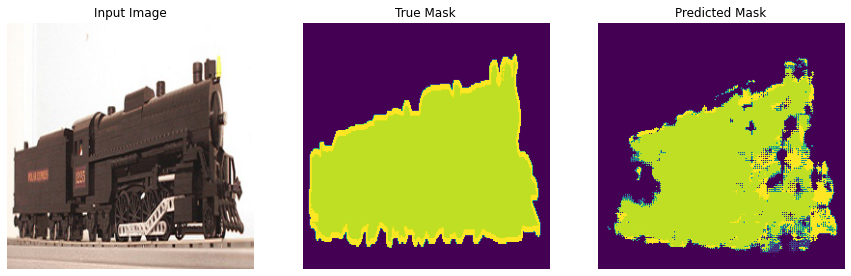

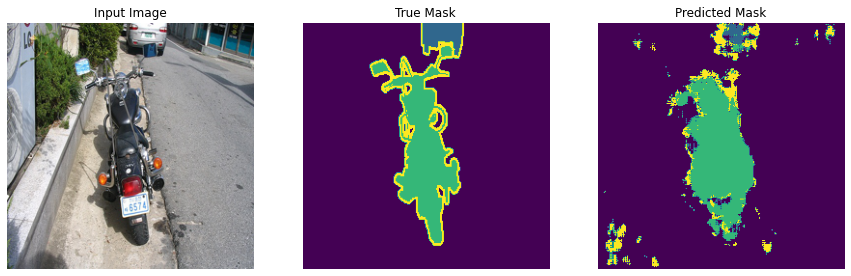

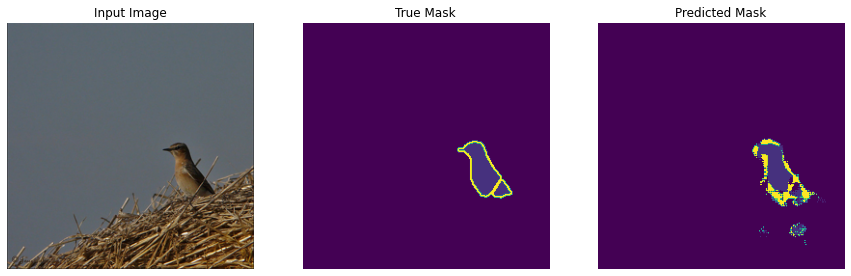

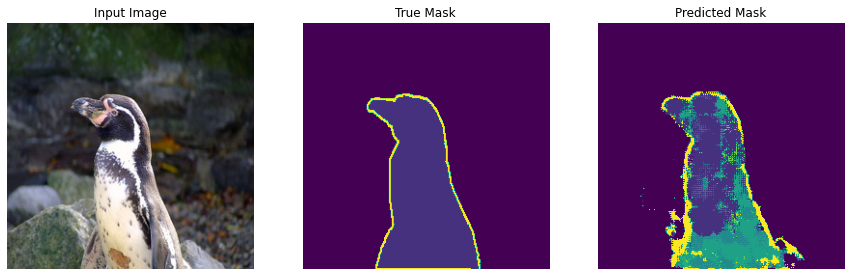

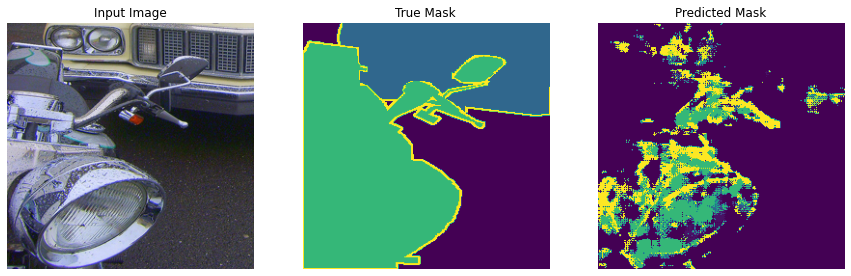

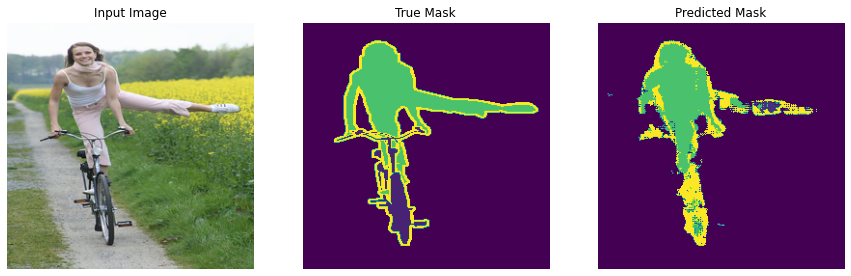

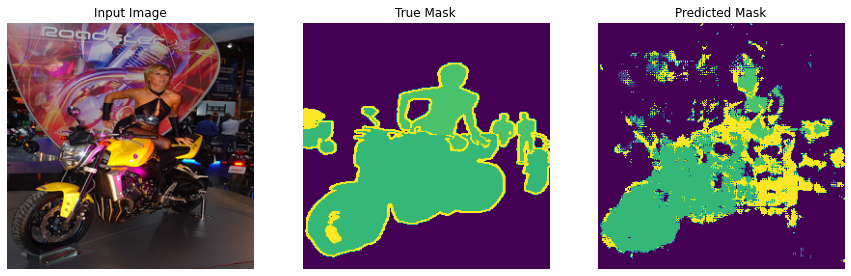

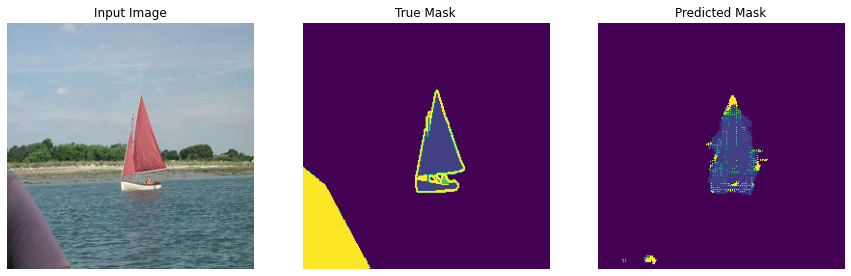

In [34]:
show_predictions(test_dataset.shuffle(buffer_size=64), num =10)

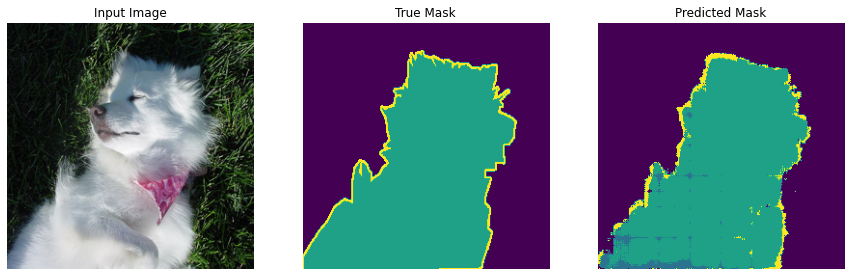

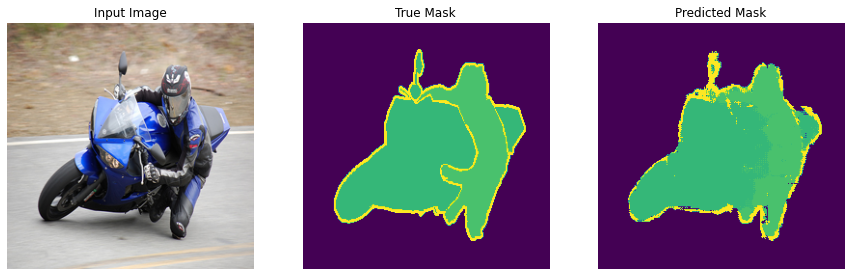

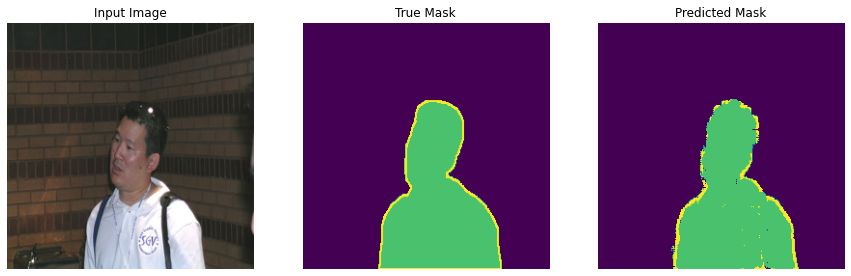

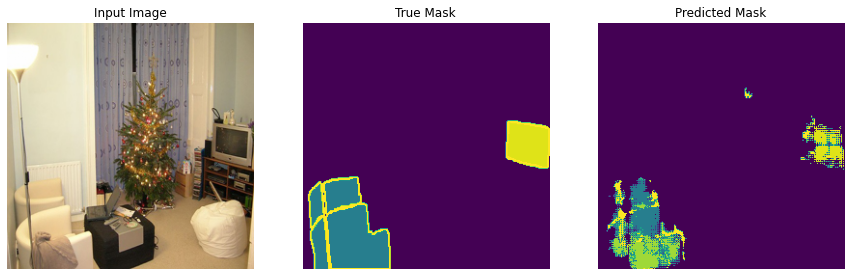

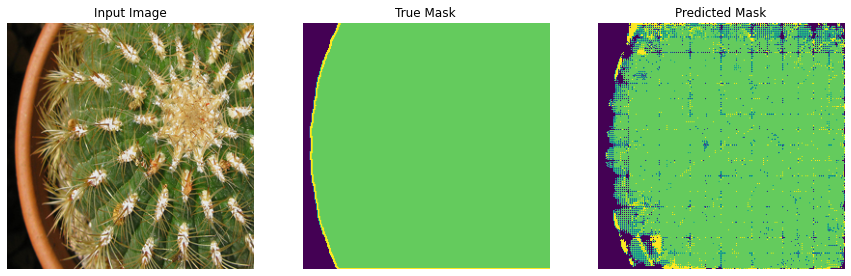

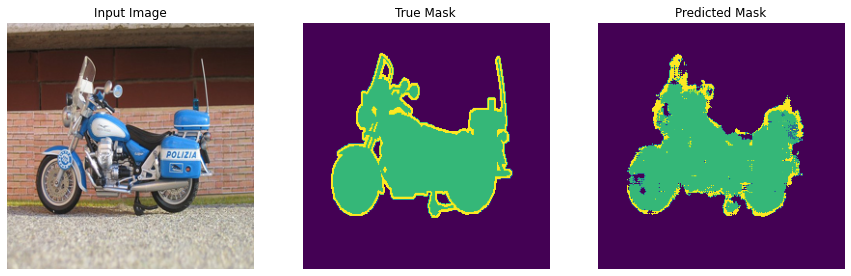

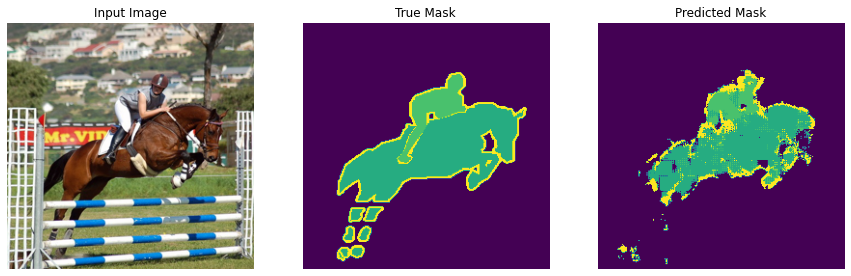

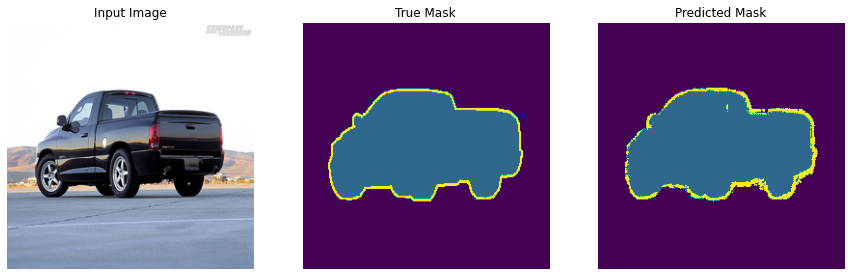

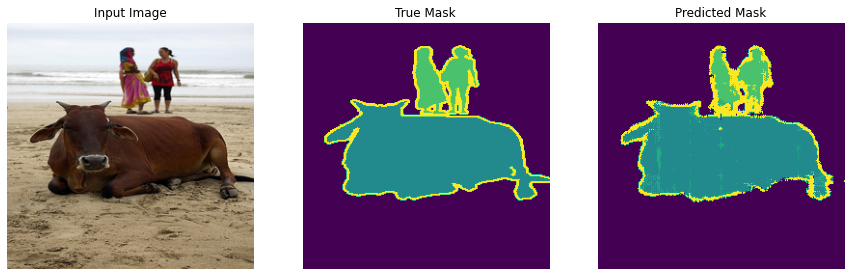

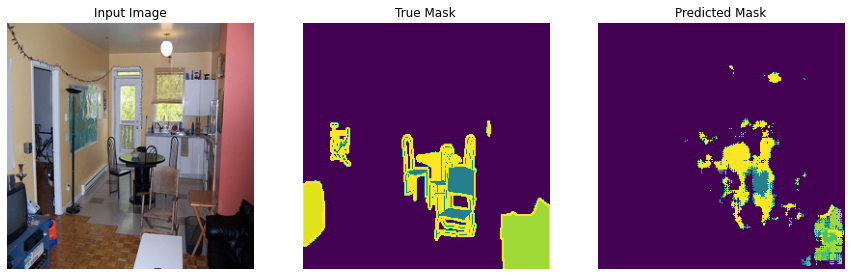

In [35]:
show_predictions(val_dataset.shuffle(buffer_size=64), num =10)

In [36]:
model.evaluate(test_dataset)

46/46 [==============================] - 4s 82ms/step - loss: 0.7046 - accuracy: 0.8165


[0.7046099305152893, 0.8165468573570251]

### Model inference and extract mask

In [37]:
!mkdir source
!mkdir mask

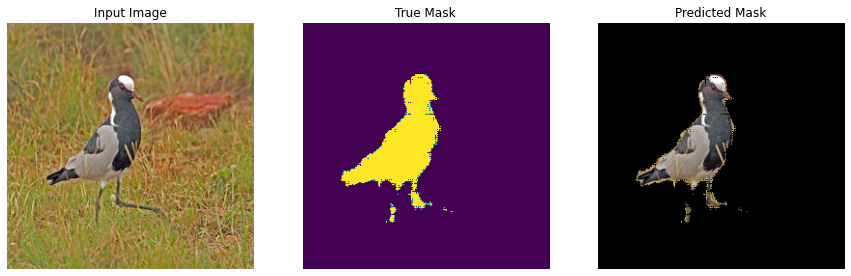

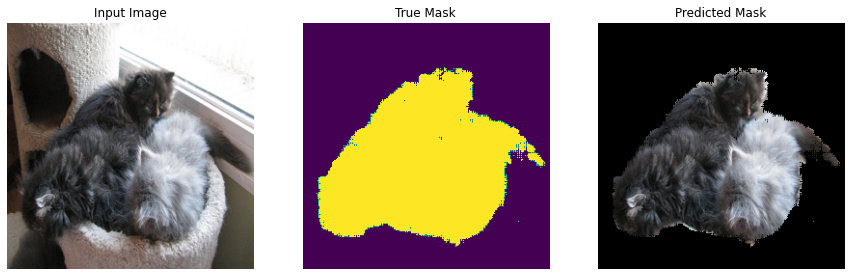

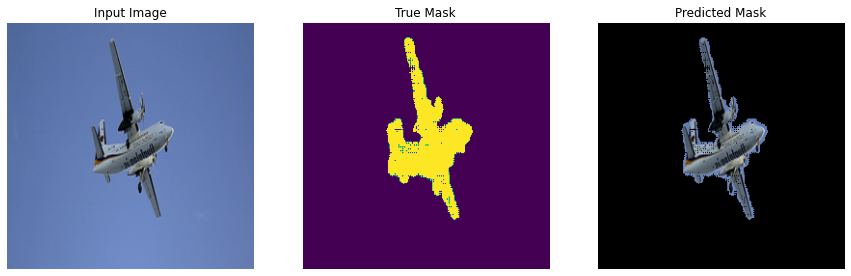

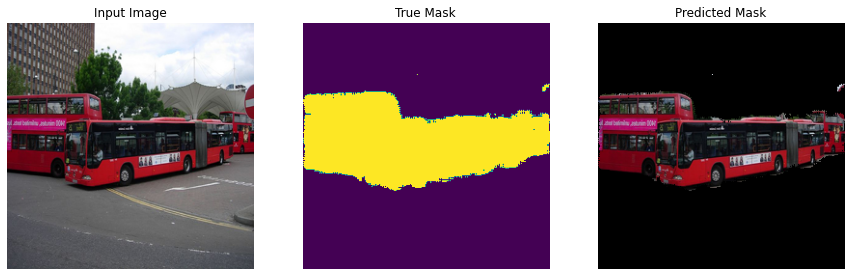

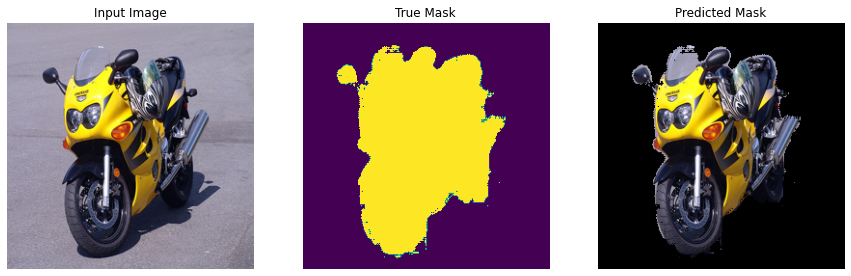

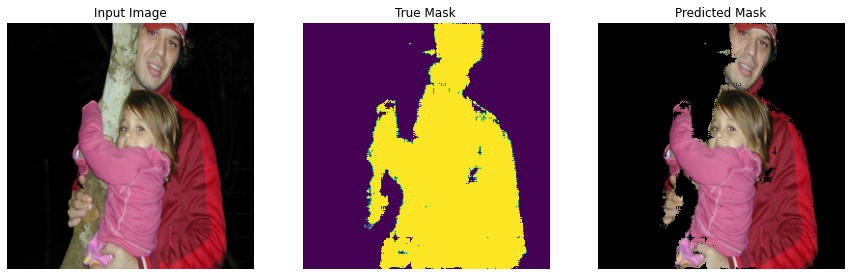

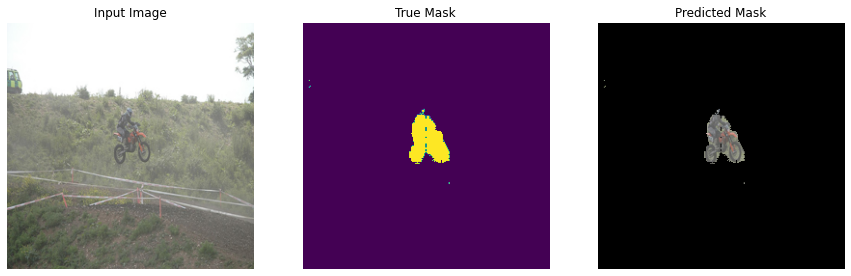

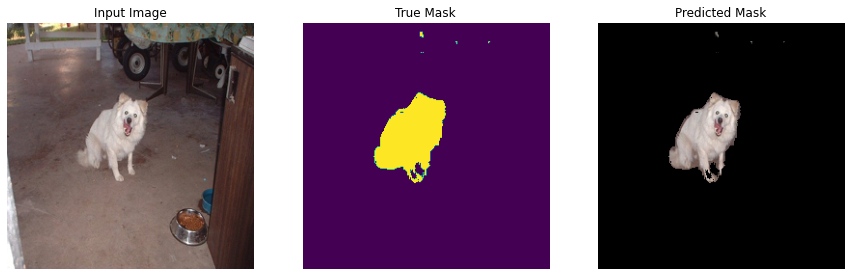

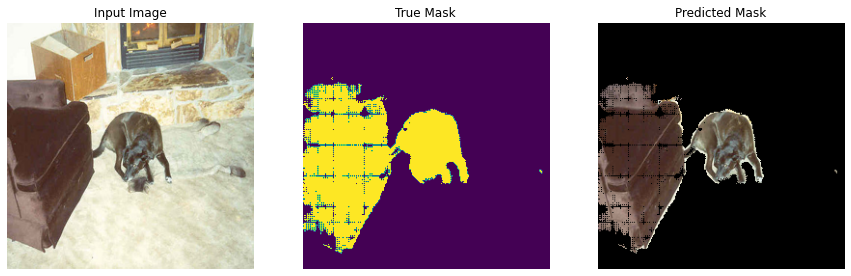

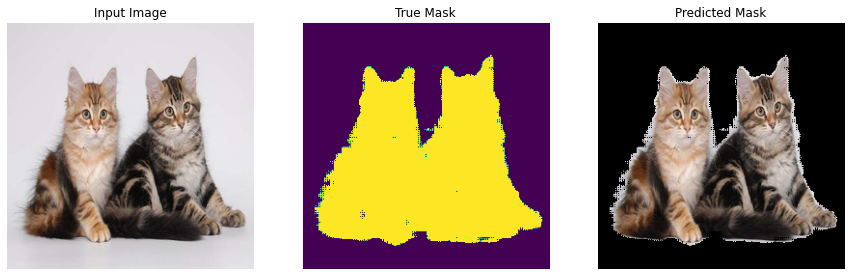

In [38]:
cnt = 0
for image, mask in train_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1

In [39]:
cat_img = np.array(Image.open("../input/pascal-voc-2012/VOC2012/JPEGImages/2007_000241.jpg").resize((256, 256)))
pred_mask = model.predict(cat_img[np.newaxis,...])
mask = create_mask(pred_mask)
mask = np.array(mask!=0, dtype=int)